<a href="https://colab.research.google.com/github/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/supplementary/E21_Discussion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Challenges of Getting a Higher Education in an AI Driven World**

# **Importing Modules**

In [ ]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import math
from numpy import linalg
import sympy

from sympy import symbols
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
init_vprinting(pretty_print=True)

import plotly.graph_objects as go

In [ ]:
class MugasRigidBodyFunctions:

    def __init__(self):
        pass

    def simulate_dy_system(self, dynamic_system_model, t_max, dt, x0, sys_para, fig_title, x_label, y_label):
        t = np.linspace(0, t_max, int(t_max/dt+1))
        sol = odeint(dynamic_system_model, x0, t, args=(sys_para,))

        fig = go.Figure()
        for sol_col in sol.T:
            fig.add_trace(go.Scatter(x=t, y=sol_col, mode='lines+markers'))

        fig.update_layout(title=fig_title, xaxis=dict(title=x_label), yaxis=dict(title=y_label))
        fig.show()
        return t, sol, fig

    def hat_matrix(self, x):
        return np.array([[0., -x[2], x[1]],[x[2], 0., -x[0]],[-x[1], x[0], 0.]])

    def q_from_axis_angles(self, theta, unit_axis):
        return np.concatenate(([np.cos(theta/2)], np.sin(theta/2) * np.array(unit_axis)))

    def r_from_quaternions(self, q):
        q0, w = q[0], q[1:]
        return np.identity(3) + 2*q0*self.hat_matrix(w) + 2*self.hat_matrix(w) @ self.hat_matrix(w)

    def rotation_matrix_2_euler_angles(self, R):
        # Handle unique solutions and default cases
        if R[2, 2] < 1:
            if R[2, 2] > -1:
                return np.pi - math.atan2(R[0, 2], R[1, 2]), math.acos(R[2, 2]), np.pi - math.atan2(R[2, 0], -R[2, 1])
            return -math.atan2(R[0, 1], -R[0, 0]), np.pi, 0
        return math.atan2(R[0, 1], R[0, 0]), 0, 0

    def re3_equals_gamma(self, gamma):
        theta = math.acos(gamma[2])
        n = [-gamma[1]/np.sin(theta), gamma[0]/np.sin(theta), 0]
        return self.r_from_quaternions(self.q_from_axis_angles(theta, n))

    def rotate_and_translate(self, object_vertices, R, o):
        return np.array([[o[0], o[1], o[2]]]).T + R @ object_vertices

    def add_orth_norm_frame(self, fig, o, R, axis_range, axis_color):
        e = [np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1])]
        b = [R @ ei for ei in e]

        for bi in b:
            fig.add_trace(go.Scatter3d(
                x=[o[0], o[0] + bi[0]],
                y=[o[1], o[1] + bi[1]],
                z=[o[2], o[2] + bi[2]],
                hoverinfo='x+y+z',
                mode='lines',
                line=dict(width=8, color=axis_color)
            ))

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(range=axis_range[0], autorange=False),
                yaxis=dict(range=axis_range[1], autorange=False),
                zaxis=dict(range=axis_range[2], autorange=False),
                aspectratio=dict(x=1, y=1, z=1)
            )
        )
        return fig

    def animate_particle_motion(self, xx, axis_range, fig_title):
        x_vals, y_vals, z_vals = zip(*xx)

        trace_particle = go.Scatter3d(
            x=[x_vals[0]], y=[y_vals[0]], z=[z_vals[0]],
            mode="markers",
            marker=dict(color="red", size=10)
        )

        trace_path = go.Scatter3d(
            x=x_vals, y=y_vals, z=z_vals,
            mode="lines",
            line=dict(color="blue", width=2),
            name='Path'
        )

        layout = go.Layout(
            title_text=fig_title,
            hovermode="closest",
            updatemenus=[dict(
                type="buttons",
                buttons=[dict(
                    label="Play",
                    method="animate",
                    args=[None]
                )]
            )],
            scene=dict(
                xaxis=dict(range=axis_range[0], autorange=False),
                yaxis=dict(range=axis_range[1], autorange=False),
                zaxis=dict(range=axis_range[2], autorange=False),
                aspectratio=dict(x=1, y=1, z=1)
            )
        )

        frames = [go.Frame(
            data=[go.Scatter3d(
                x=[point[0]], y=[point[1]], z=[point[2]],
                mode="markers",
                marker=dict(color="red", size=10),
                name='Particle'
            )]) for point in xx]

        fig = go.Figure(data=[trace_particle, trace_path], layout=layout, frames=frames)
        fig.show()
        return fig



    def cube_vertices(self, cube_dimensions):
        l, w, h = cube_dimensions['l'], cube_dimensions['w'], cube_dimensions['h']
        xp, yp, zp = cube_dimensions['xp'], cube_dimensions['yp'], cube_dimensions['zp']

        X = [-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]
        Y = [-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]
        Z = [-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]

        return [X, Y, Z]

    def animated_cube_flat_shading(self, cubeVertices,figTitle):
        fig = go.Figure(
            frames=[go.Frame(data=[
            go.Mesh3d(
                # 8 vertices of a cube
                x=xx[0][0],
                y=xx[0][1],
                z=xx[0][2],
                # i, j and k give the vertices of triangles
                i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
                j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
                k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
                name='y',
                opacity=0.6,
                color='#DC143C',
                flatshading = True)]) for xx in cubeVertices])

        fig.add_trace(go.Mesh3d(
                # 8 vertices of a cube
                x=cubeVertices[0][0][0],
                y=cubeVertices[0][0][1],
                z=cubeVertices[0][0][2],
                # i, j and k give the vertices of triangles
                i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
                j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
                k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
                name='y',
                opacity=0.6,
                color='#DC143C',
                flatshading = True)
            )

        duration=10;
        fig.update_layout(
            title=figTitle,width=600,height=600,
            scene=dict(xaxis=dict(range=[-5., 5.], autorange=False),yaxis=dict(range=[-5., 5.], autorange=False),zaxis=dict(range=[-5., 5.], autorange=False),aspectratio=dict(x=1, y=1, z=1),),
            updatemenus=[dict(type="buttons",
                                buttons=[dict(label="Play",
                                                method="animate",
                                                args=[None, {"frame": {"duration": duration},"mode": "immediate","fromcurrent": True, "transition": {"duration": duration, "easing": "linear"},}]
                                                )])])
        len(fig.frames)
        fig.show()
        return fig


    def eulers_method(self, dt, Tmax, parameters, ICs):
        M, II = parameters['M'], parameters['II']
        invII = np.linalg.inv(II)
        timeSteps = np.arange(0, Tmax+dt, dt)
        R, o, omega, doto, Xc = ICs[0][0], ICs[0][1], ICs[1], ICs[2], ICs[3]
        spi = R @ II @ R.T @ omega
        p = M * doto
        Xout = [ICs]

        for t in timeSteps:
            taue, fe = externalForceModel(self, parameters, X)
            taua, fa = actuator(self, parameters, t, X, taue, fe)

            dspi = taue + taua
            dp = fe + fa

            if np.linalg.norm(omega) >= 0.0001:
                nomega = omega / np.linalg.norm(omega)
                thetaomegat = dt * np.linalg.norm(omega)
                qomegat = np.concatenate(([np.cos(thetaomegat/2)], np.sin(thetaomegat/2) * nomega))
                R = self.r_from_quaternionsns(qomegat) @ R

            o += dt * doto
            spi += dt * dspi
            p += dt * dp
            doto = p / M
            omega = R @ invII @ R.T @ spi
            X = [[R, o], omega, doto, Xc]
            Xout.append(X)

        return Xout

    def runga_kutta_method(self, dt, Tmax, parameters, ICs):
        M, II = parameters['M'], parameters['II']
        invII = np.linalg.inv(II)
        timeSteps = np.arange(0, Tmax+dt, dt)
        X=ICs;
        Xout=[X];

        for t in timeSteps:
            Y1 = self.rk4_function(0.5*dt, X, t, X, parameters)
            Y2 = self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters)
            Y3 = self.rk4_function(dt, X, t+0.5*dt, Y2, parameters)

            values = [self.rigid_body_system(parameters, t+i*dt, X_j) for i, X_j in enumerate([X, Y1, Y2, Y3])]
            thetas, n_omegas, dotos, dps, dspis, dXcs = zip(*values)

            omegak = (dt/6.0) * sum(t * n for t, n in zip(thetas, n_omegas))
            nomegak = omegak/np.linalg.norm(omegak) if np.linalg.norm(omegak) >= 0.0001 else np.array([0, 0, 0])
            qomegak = np.concatenate(([np.cos(np.linalg.norm(omegak)/2)], np.sin(np.linalg.norm(omegak)/2) * nomegak))
            Rk = self.r_from_quaternions(qomegak) @ X[0][0]

            ok = X[0][1] + dt * np.mean(dotos)
            pk = X[2] + dt * np.mean(dps)
            spik = X[0][0] @ II @ X[0][0].T @ X[1] + dt * np.mean(dspis)
            Xck = X[3] + dt * np.mean(dXcs)

            omegak = Rk @ invII @ Rk.T @ spik
            X = [[Rk, ok], omegak, pk, Xck]
            Xout.append(X)

        return Xout

    def rk4_function(self, dtk, X, tk, Xk, parameters):
        M, II = parameters['M'], parameters['II']
        thetaomega1, nomega1, doto1, dp1, dspi1, dXc1 = self.rigid_body_system(parameters, tk, Xk)
        qomega1 = np.concatenate(([np.cos(dtk*thetaomega1/2)], np.sin(dtk*thetaomega1/2) * nomega1))
        R1 = self.r_from_quaternions(qomega1) @ X[0][0]
        p1 = X[2] + dtk * dp1
        spi1 = X[0][0] @ II @ X[0][0].T @ X[1] + dtk * dspi1
        omega1 = R1 @ np.linalg.inv(II) @ R1.T @ spi1
        X1 = [[R1, X[0][1] + dtk * doto1], omega1, p1, X[3] + dtk * dXc1]
        return X1


    def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
        XX=self.cube_vertices(cubeDimensions);

        #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
        Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);
        ICR=ICs[0][0];
        XX0=ICR @ XX;

        rotatedVertices=[[XX0]]
        for X in Xs:
        #print(X[0])
            R=X[0][0];
            o=X[0][1];
            XXi=self.rotate_and_translate(XX,R,o);
            XX0=XXi;
            rotatedVertices+=[[XX0]];
        return rotatedVertices


    def rigid_body_system(self, parameters, t, X):
        barX, M = parameters['CM'], parameters['M']
        R, omega, p = X[0][0], X[1], X[2]

        taue, fe = externalForceModel(self, parameters, X)
        taua, fa = actuator(self, parameters, t, X, taue, fe)

        doto = p / M
        dp = fe + fa
        dspi = taue + taua
        dXc = np.array([0., 0., 0.])  # External Dynamics #controller_dynamics(self, t, X, taue, fe, parameters)

        if np.linalg.norm(omega) >= 0.0001:
            nomega = omega / np.linalg.norm(omega)
            thetaomega = np.linalg.norm(omega)
        else:
            nomega = np.array([0, 0, 0])
            thetaomega = 0

        return [thetaomega, nomega, doto, dp, dspi, dXc]

    def animate_2D_scatter_plot(self, x, YY, xlabel, ylabel, title):
        layout = go.Layout(
            xaxis={'title': xlabel},
            yaxis={'title': ylabel, 'range': [1.1 * YY.min(), 1.1 * YY.max()]},
            title={'text': title, 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
            scene=dict(aspectratio=dict(x=1, y=1)),
            hovermode="closest",
            updatemenus=[dict(type="buttons",
                            buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]
        )

        frames = [go.Frame(data=[go.Scatter(x=x, y=y)]) for y in YY]

        fig = go.Figure(data=[go.Scatter(x=x, y=YY[0, :])], layout=layout, frames=frames)

        # fig.show()
        return fig


def LinearSystemModel(X, t, A):
  dXdt=A @ X;
  return dXdt

mr=MugasRigidBodyFunctions()

# ***Question***

Find $\alpha$ the coefficient of the partial fraction expansion of
\begin{align*}
G(s)=\frac{1}{s^2+2\zeta\omega_n s+\omega_n^2}=\frac{i\alpha}{s+p}-\frac{i{\alpha}}{s+\bar{p}}
\end{align*}

where $\zeta<1$

## Procedure

Find the roots of
\begin{align*}
f(s)=s^2+2\zeta\omega_n s+\omega_n^2
\end{align*}

In [ ]:
s, omega_n , zeta = symbols('s omega_n zeta', real=True)
fs = s**2 + (2*zeta*omega_n*s) + (omega_n**2)
solve(fs, s)

⎡   ⎛        ________⎞     ⎛        ________⎞⎤
⎢   ⎜       ╱  2     ⎟     ⎜       ╱  2     ⎟⎥
⎣ωₙ⋅⎝-ζ - ╲╱  ζ  - 1 ⎠, ωₙ⋅⎝-ζ + ╲╱  ζ  - 1 ⎠⎦

In [ ]:
import matplotlib.pyplot as plt

# Define parameters
omega_n = 1  # Natural frequency
zeta = np.linspace(0, 2, 500)  # Damping ratio range

# Compute roots
s1 = -omega_n * zeta + omega_n * np.sqrt(zeta**2 - 1 + 0j)  # Root 1
s2 = -omega_n * zeta - omega_n * np.sqrt(zeta**2 - 1 + 0j)  # Root 2

# Separate real and imaginary parts
s1_real, s1_imag = s1.real, s1.imag
s2_real, s2_imag = s2.real, s2.imag

# Plot the roots
plt.figure(figsize=(10, 6))

plt.plot(s1_real, s1_imag, label="Root 1 (Real vs Imag)", color="blue")
plt.plot(s2_real, s2_imag, label="Root 2 (Real vs Imag)", color="red")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.axvline(0, color="black", linestyle="--", linewidth=0.8)

plt.title("Roots of the Polynomial $\omega_{n}^2 + 2 \omega_{n} s \zeta + s^2$")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
s = symbols('s')

In [ ]:
omega_n , zeta = symbols('omega_n zeta', real=True)
G = 1/(s**2 + (2*zeta*omega_n*s) + (omega_n**2))
G

         1         
───────────────────
  2               2
ωₙ  + 2⋅ωₙ⋅s⋅ζ + s 

In [ ]:
Gs = G.subs({zeta:0.9,omega_n:1.1})
Gs

In [ ]:
apart(Gs, full=True).doit()

#***Question***

Find the eigenvalues and eigenvectors of

\begin{align*}
A=\left[\begin{matrix}0 & 1\\- \omega_{n}^{2} & - 2 \omega_{n} \zeta\end{matrix}\right]
\end{align*}

In [ ]:
omega_n , zeta = symbols('omega_n zeta', real=True)
E = Matrix([[0,1],[-omega_n**2, -2*zeta*omega_n]])
E

⎡ 0       1   ⎤
⎢             ⎥
⎢   2         ⎥
⎣-ωₙ   -2⋅ωₙ⋅ζ⎦

In [ ]:
E.eigenvals()

⎧   ⎛       _________________⎞        ⎛       _________________⎞   ⎫
⎨ωₙ⋅⎝-ζ - ╲╱ (ζ - 1)⋅(ζ + 1) ⎠: 1, ωₙ⋅⎝-ζ + ╲╱ (ζ - 1)⋅(ζ + 1) ⎠: 1⎬
⎩                                                                  ⎭

In [ ]:
E.eigenvects()

⎡⎛                                  ⎡⎡               _________________⎤⎤⎞  ⎛                       ↪
⎢⎜                                  ⎢⎢  2⋅ζ   -ζ - ╲╱ (ζ - 1)⋅(ζ + 1) ⎥⎥⎟  ⎜                       ↪
⎢⎜   ⎛       _________________⎞     ⎢⎢- ─── - ────────────────────────⎥⎥⎟  ⎜   ⎛       ___________ ↪
⎢⎜ωₙ⋅⎝-ζ - ╲╱ (ζ - 1)⋅(ζ + 1) ⎠, 1, ⎢⎢  ωₙ               ωₙ           ⎥⎥⎟, ⎜ωₙ⋅⎝-ζ + ╲╱ (ζ - 1)⋅(ζ ↪
⎢⎜                                  ⎢⎢                                ⎥⎥⎟  ⎜                       ↪
⎣⎝                                  ⎣⎣               1                ⎦⎦⎠  ⎝                       ↪

↪             ⎡⎡               _________________⎤⎤⎞⎤
↪             ⎢⎢  2⋅ζ   -ζ + ╲╱ (ζ - 1)⋅(ζ + 1) ⎥⎥⎟⎥
↪ ______⎞     ⎢⎢- ─── - ────────────────────────⎥⎥⎟⎥
↪  + 1) ⎠, 1, ⎢⎢  ωₙ               ωₙ           ⎥⎥⎟⎥
↪             ⎢⎢                                ⎥⎥⎟⎥
↪             ⎣⎣               1                ⎦⎦⎠⎦

In [ ]:
init_printing()
E.eigenvects()

In [ ]:
init_printing(pretty_print=False)
E.eigenvects()

#Describe the behavior of this system

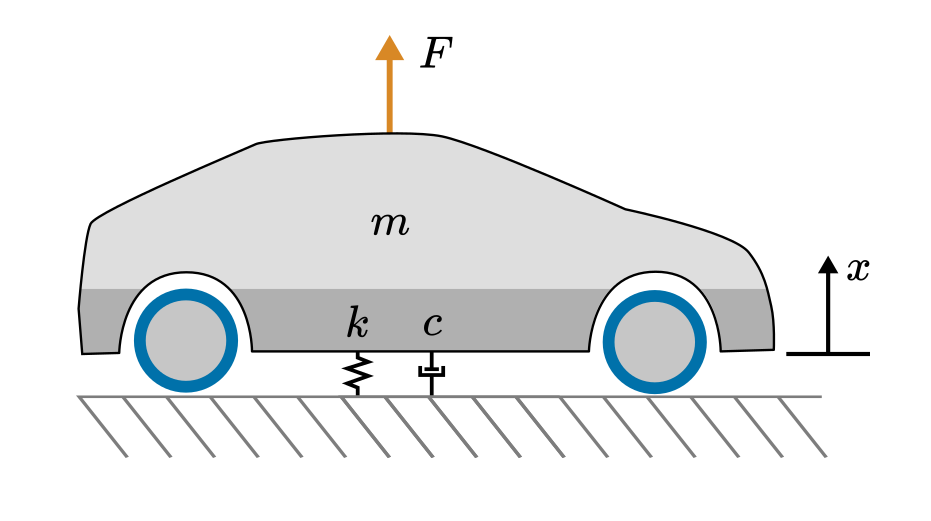

Newtons equations for this approximately modelled system will give
\begin{align*}
m\ddot{x}+c\dot{x}+kx=F
\end{align*}

This can be reduced to the form

\begin{align*}
\ddot{x}+2\zeta \omega_n\dot{x}+\omega_n^2x=\frac{1}{m}F
\end{align*}
where we have set $\omega_n^2=k/m$ and $2\zeta\omega_n=c/m$.

The transfer function representation of this system is
\begin{align*}
X(s)=G(s)U(s)
\end{align*}
where $U(s)=F(s)/m$ and
\begin{align*}
G(s)=\frac{1}{\omega_{n}^{2} + 2 \omega_{n} s \zeta + s^{2}}
\end{align*}

This system can also be written down as a first order matrix ODE
\begin{align*}
\dot{Y}=AY+BF
\end{align*}
where
\begin{align*}
A=\left[\begin{matrix}0 & 1\\- \omega_{n}^{2} & - 2 \omega_{n} \zeta\end{matrix}\right]
\end{align*}
and
\begin{align*}
B=\left[\begin{matrix}0 \\\frac{1}{m}\end{matrix}\right]
\end{align*}

In [ ]:
m=1; k=10; c=float(m*2*0.1*sqrt(k/m));
A=np.array([[0,1],[-k/m,-c/m]]);
[t,sol,fig]=mr.simulate_dy_system(LinearSystemModel, 10,0.01, [1,0], A, 'Spring Mass System', 'Time / t', 'x')

#WEC

https://chatgpt.com/share/67558833-bb70-800b-9312-11b9ee8c0b6d

#Access this Notebook

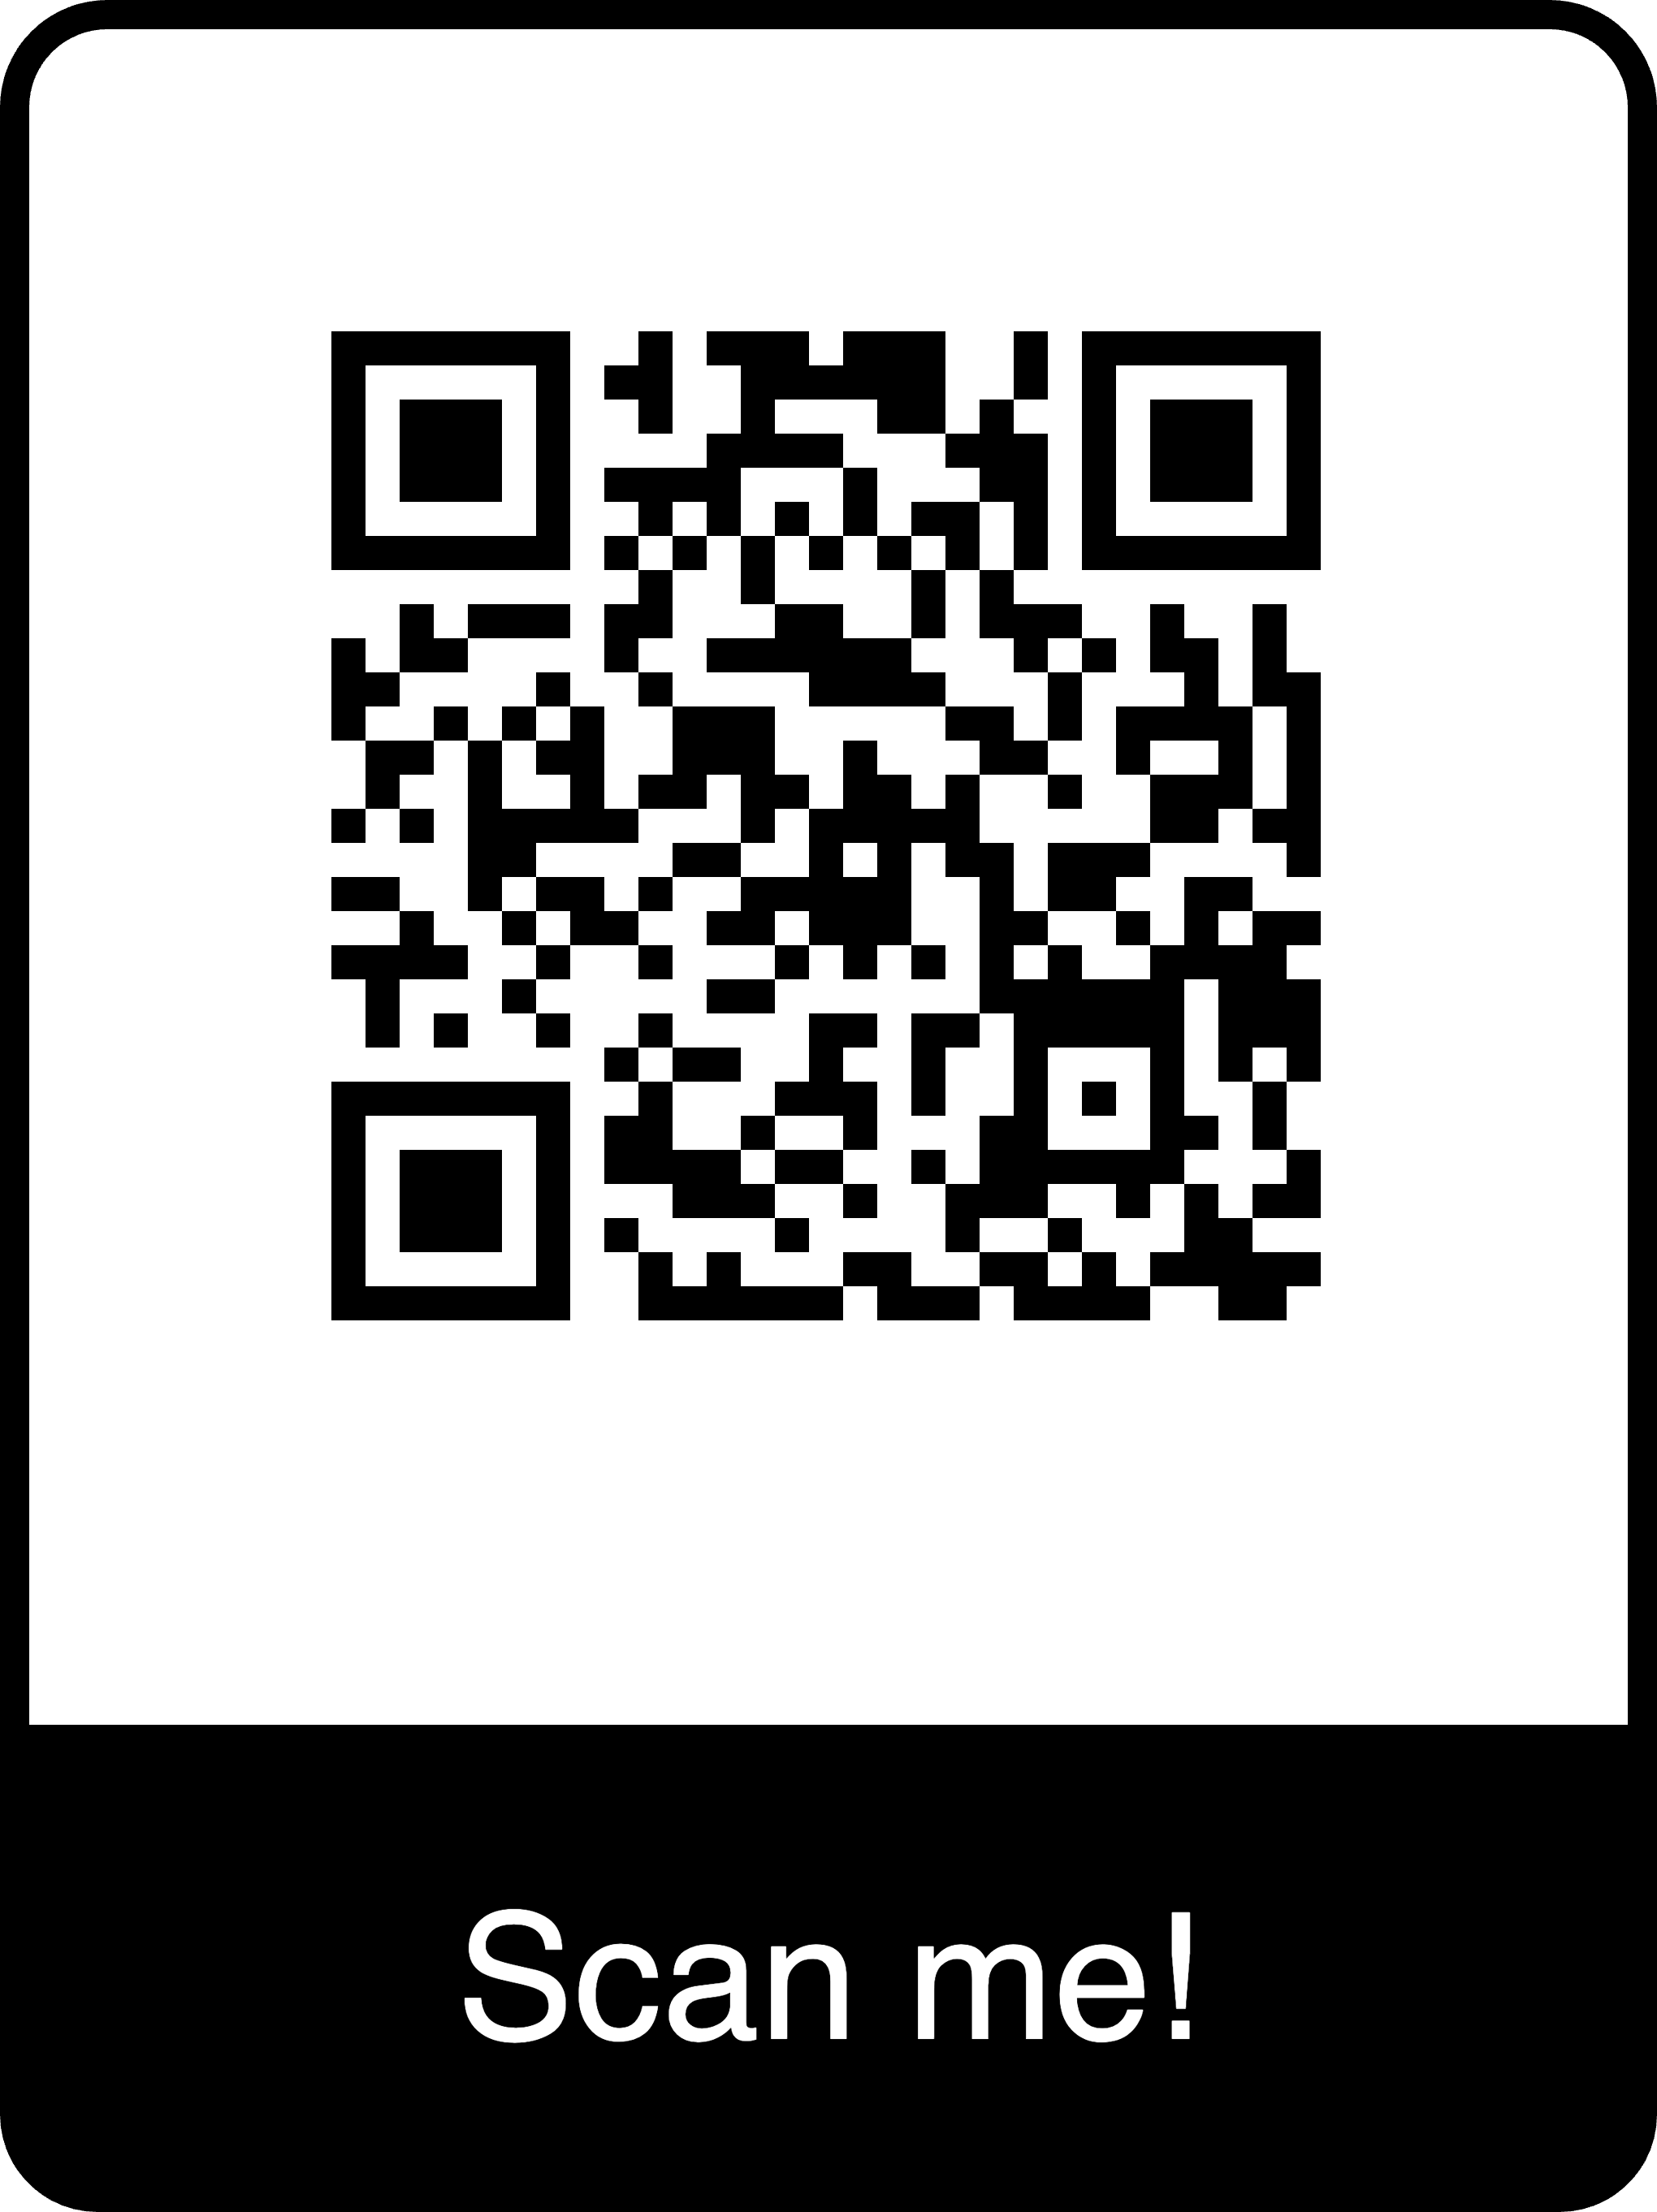